# 1. 引入資料

郵箱111年貨態資料: 快遞狀態說明

### 寄件狀態(1)
- `30`：交寄郵件（用戶寄件）
- `35`：逆物流退貨（用戶退件）
- `75`：逾期逕退寄件人
- `95`：退回（箱）郵件投遞中
- `120`：物流士投件（到達賣家ｉ郵箱）
- `20`：物流士投件（到達買家ｉ郵箱）

### 取件狀態(0)
- `40`：物流士收攬
- `60`：逾期取件（買家取件逾期通知）
- `70`：逾期轉招領（買家郵件逾期回收）
- `71`：郵局強制回收
- `74`：物流商（共用櫃體廠商）強制回收
- `80`：領取郵件（買家ｉ郵箱取件）
- `160`：逾期取件（賣家取件逾期通知）
- `170`：逾期轉招領（賣家郵件逾期回收）
- `171`：郵局強制回收
- `180`：領取郵件（賣家ｉ郵箱取件）
- `72`：寄件人提出郵件撤回

### 刪除
- `null/0`：接單
- `10`：投箱失敗

In [1]:
import pandas as pd
from IPython.display import display

# 定義每個檔案的路徑
# file_path_1 = r"postoddice_data\提供資料-1-1.ｉ郵箱資訊.csv"
# file_path_2 = r"postoddice_data\提供資料-2-1-3.new_ｉ郵箱111年寄件資料.csv"
file_path_3 = r"postoddice_data\提供資料-2-2-3.new_ｉ郵箱111年貨態資料.csv"

# # 讀取每個檔案，假設沒有檔頭
# ibox = pd.read_csv(file_path_1)
# sent = pd.read_csv(file_path_2)
status = pd.read_csv(file_path_3)

# # 使用 display() 函數顯示每個資料框
# print("郵箱資訊:")
# display(ibox.head())

# print("ｉ郵箱111年寄件資料:")
# display(sent.head())

print("郵箱111年貨態資料:")
display(status.head())

郵箱111年貨態資料:


箱體ID  儲格ID  收件所屬公司  快遞狀態  收件人手機_已取代  機器號碼_局號                 資料建立日期時間  \
0  1797    19       3    30        1.0   220031  2022-01-01 00:05:57.820   
1  2372    15       3    30        2.0   330033  2022-01-01 00:05:23.250   
2  2278    16       3    30        3.0   800024  2022-01-01 00:02:51.280   
3  1418     8       3    80        4.0   830019  2022-01-01 00:01:03.520   
4  2372    19       3    30        5.0   330033  2022-01-01 00:06:19.990   

  儲格尺寸_寬_高_深  
0   14*17*47  
1   34*17*47  
2   34*17*47  
3   34*27*47  
4   14*17*47

# 2. filtered
找出郵局局號100171(指南分局)的資料

In [2]:
status_filtered = status[(status['機器號碼_局號'] == 100171)]

# 3. data_clean
- 加入尺寸欄位

In [3]:
import numpy as np

# '建立日期時間' 轉換成 datetime 格式
status_filtered['資料建立日期時間'] = pd.to_datetime(status['資料建立日期時間'])

# 刪除指定欄位
status_filtered = status_filtered.drop(columns=["收件人手機_已取代", "收件所屬公司", "機器號碼_局號"])

# 寄件和取件狀態清單
put_status = [30, 35, 75, 95, 120, 20]  # 寄件狀態
pickup_status = [40, 60, 70, 71, 74, 80, 160, 170, 171, 180, 72]  # 取件狀態

# 確保 '快遞狀態' 欄位是數字型別
status_filtered['快遞狀態'] = pd.to_numeric(status_filtered['快遞狀態'], errors='coerce')

# 將數據依據寄件和取件進行標記
status_filtered['放(1)/取(0)'] = np.where(status_filtered['快遞狀態'].isin(put_status), 1,  # 寄件為 1 
                             np.where(status_filtered['快遞狀態'].isin(pickup_status), 0, np.nan))  # 取件為 0

# 去除類別中 NaN 的數據（僅保留寄件與取件）
status_filtered = status_filtered.dropna(subset=['放(1)/取(0)'])

# 四代櫃
# 定義尺寸到儲格名稱的對應關係
size_to_type = {
    '14*17*47': '小方格',
    '34*17*47': '中格',
    '34*27*47': '大格'
}
宅配價格 = {
    '小方格': 60,
    '中格': 65,
    '大格': 70
}

箱對箱價格 = {
    '小方格': 55,
    '中格': 60,
    '大格': 60
}

# 新增 '儲格尺寸' 欄位，根據 '儲格尺寸_寬_高_深' 欄位的值進行替換
status_filtered['儲格尺寸'] = status_filtered['儲格尺寸_寬_高_深'].map(size_to_type)

# 新增「箱到宅價錢(元)」和「箱到箱價錢(元)」欄位，根據儲格尺寸對應到費用字典
status_filtered['箱到宅價錢(元)'] = status_filtered['儲格尺寸'].map(宅配價格)
status_filtered['箱到箱價錢(元)'] = status_filtered['儲格尺寸'].map(箱對箱價格)

# 刪除原始的 '儲格尺寸_寬_高_深' 欄位
status_filtered.drop(columns=['儲格尺寸_寬_高_深'], inplace=True)

# 新增建立星期、日類型和時間區間欄位
status_filtered['建立星期'] = status_filtered['資料建立日期時間'].dt.day_name()

# 判斷平日/假日
status_filtered['日類型'] = status_filtered['建立星期'].apply(lambda x: '假日' if x in ['Saturday', 'Sunday'] else '平日')

# 定義時間區間函式
def get_period(hour):
    if 0 <= hour < 6:
        return '凌晨'
    elif 6 <= hour < 12:
        return '早上'
    elif 12 <= hour < 18:
        return '下午'
    else:
        return '晚上'

# 新增時間區間欄位
status_filtered['時間區間'] = status_filtered['資料建立日期時間'].dt.hour.apply(get_period)

status_filtered


C:\Users\Ella\AppData\Local\Temp\ipykernel_15428\893257798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  status_filtered['資料建立日期時間'] = pd.to_datetime(status['資料建立日期時間'])


箱體ID  儲格ID  快遞狀態                資料建立日期時間  放(1)/取(0) 儲格尺寸  箱到宅價錢(元)  \
1143     1779     2    20 2022-01-01 10:27:11.990        1.0  小方格        60   
1714     1779     2    80 2022-01-01 12:32:50.300        0.0  小方格        60   
2054     2621    15    20 2022-01-01 13:51:49.220        1.0   中格        65   
2912     1779     5    20 2022-01-01 16:43:39.830        1.0   中格        65   
3037     2233    36    80 2022-01-01 17:20:29.840        0.0   中格        65   
...       ...   ...   ...                     ...        ...  ...       ...   
9511155  2621    28    30 2022-12-30 22:19:51.250        1.0   大格        70   
9512436  2233    20    80 2022-12-31 09:19:54.530        0.0  小方格        60   
9515516  2621    16    20 2022-12-31 16:34:31.740        1.0   中格        65   
9515836  2621    16    80 2022-12-31 17:30:31.300        0.0   中格        65   
9516045  2621    38    80 2022-12-31 18:03:15.920        0.0   大格        70   

         箱到箱價錢(元)      建立星期 日類型 時間區間  
1143           55  Saturday  假日   早上  
1714           55  Saturday  假日   下午  
2054           60  Saturday  假日   下午  
2912           60  Saturday  假日   下午  
3037           60  Saturday  假日   下午  
...           ...       ...  ..  ...  
9511155        60    Friday  平日   晚上  
9512436        55  Saturday  假日   早上  
9515516        60  Saturday  假日   下午  
9515836        60  Saturday  假日   下午  
9516045        60  Saturday  假日   晚上  

[5310 rows x 11 columns]

# 轉換 1 -> 0 Utilization T 分析說明

本指引旨在計算「從 類別 == 1 到 類別 == 0 所花費的時間分布」，並以「一天 (1440 分鐘)」為單位來呈現計算結果。結果將遵循時間區間的條件 (每六小時為一區間)，即便某些轉換過程超過 6 小時仍然會進行區間計算。

## 步驟 1：篩選並分組

1. 針對資料進行分組，以 **箱體ID** 和 **儲格ID** 作為主要分組條件。
2. 在每組 (箱體ID, 儲格ID) 的資料中，篩選出從 **類別 == 1** 變化至 **類別 == 0** 的紀錄，以便計算該類別轉換所花費的時間。

## 步驟 2：時間差計算

1. 在篩選出的資料中，對每組 (箱體ID, 儲格ID) 資料尋找 **類別 == 1** 和 **類別 == 0** 的時間戳，並計算兩者之間的時間差（分鐘）。
2. 若時間差在 6 小時 (360 分鐘) 以內，直接依據該時間區間進行紀錄。

## 步驟 3：超過時間區間 (6 小時) 的處理

若時間差超過 6 小時 (360 分鐘)，依據以下規則進行分段紀錄：

1. 根據『資料建立日期時間』的時間戳確定當下所處的時間區間（00:00-06:00 為「凌晨」、06:00-12:00 為「早上」、12:00-18:00 為「下午」、18:00-24:00 為「晚上」）。
2. 從時間差中逐段扣除，每次最多扣除 360 分鐘，將每段扣除的分鐘數根據所屬時間區間分別進行紀錄。以下為具體步驟：
    - 確定初始的 **類別 == 1** 的時間區間及其起始時間，例如若資料建立日期時間為「下午 12:30」，則該區間為「下午」。
    - 在當前區間（例如「下午」）中扣除到該區間的最大值時間（例如 18:00），並將這段時間（如 330 分鐘）記錄在「下午」區間。
    - 將剩餘時間進行循環判斷，按照每 6 小時的區間進行遞推紀錄。例如，若剩餘 1830 分鐘：
        - 計算 18:00-24:00 區間，記錄 360 分鐘到「晚上」。
        - 進入下一區間 (00:00-06:00)，記錄 360 分鐘到「凌晨」。
        - 依次往後遞推，直到將所有時間紀錄完畢。
    - 以時間區間紀錄完畢的樣本範例如下：

        | 類別轉換時間 (分鐘) | 時間區間 |
        | ---------------- | ------- |
        | 330            | 下午    |
        | 360            | 晚上    |
        | 360            | 凌晨    |
        | 360            | 早上    |
        | 360            | 下午    |
        | 360            | 晚上    |
        | 30             | 凌晨    |

## 步驟 4：計算時間分布

1. 根據上述結果，將所有 (箱體ID, 儲格ID) 的類別轉換時間段落的紀錄整理，統計並計算每個 6 小時區間 (360 分鐘) 為基準的分布情況。
2. 產出以下五種資料表：
    - **總體資料表**：記錄所有轉換過程的時間分布。
    - **凌晨區間資料表**：僅記錄凌晨 (00:00-06:00) 區間的時間分布。
    - **早上區間資料表**：僅記錄早上 (06:00-12:00) 區間的時間分布。
    - **下午區間資料表**：僅記錄下午 (12:00-18:00) 區間的時間分布。
    - **晚上區間資料表**：僅記錄晚上 (18:00-24:00) 區間的時間分布。

In [4]:
import pandas as pd
import numpy as np

# 定義時間區間
def get_period(hour):
    if 0 <= hour < 6:
        return '凌晨'
    elif 6 <= hour < 12:
        return '早上'
    elif 12 <= hour < 18:
        return '下午'
    else:
        return '晚上'

# 將「從 類別 == 1 到 類別 == 0」的時間差拆分為 6 小時時間段
def split_time_difference(start_time, end_time):
    time_diffs = []
    period_minutes = 360  # 每個時間區間 6 小時 = 360 分鐘
    current_time = start_time
    
    # 計算每一段的時間分配
    while current_time < end_time:
        current_period = get_period(current_time.hour)  # 確認當前時間的時間區間
        next_period_end = (current_time + pd.Timedelta(minutes=period_minutes)).replace(
            hour=(current_time.hour // 6 + 1) * 6 % 24, minute=0, second=0
        )  # 計算下一個時間區間的結束時間
        period_end = min(next_period_end, end_time)  # 取最小值（避免超過實際時間）
        
        # 計算當前時間段的分鐘數
        time_diff = int((period_end - current_time).total_seconds() // 60)
        time_diffs.append({'1到0的時間': time_diff, '時間區間': current_period})
        
        # 更新時間點
        current_time = period_end

    return time_diffs

# 篩選出所有的 (箱體ID, 儲格ID) 並計算類別 == 1 到 類別 == 0 的時間差
time_intervals = []

for (box_id, cell_id), group in status_filtered.groupby(['箱體ID', '儲格ID']):
    group = group.sort_values(by='資料建立日期時間').reset_index(drop=True)
    
    for i in range(len(group) - 1):
        if group.loc[i, '放(1)/取(0)'] == 1 and group.loc[i + 1, '放(1)/取(0)'] == 0:
            start_time = group.loc[i, '資料建立日期時間']
            end_time = group.loc[i + 1, '資料建立日期時間']
            
            # 擷取原始欄位的資料
            row_data = {
                '箱體ID': box_id,
                '儲格ID': cell_id,
                '儲格尺寸': group.loc[i, '儲格尺寸'],
                '箱到宅價錢(元)': group.loc[i, '箱到宅價錢(元)'],
                '箱到箱價錢(元)': group.loc[i, '箱到箱價錢(元)'],
                '建立星期': group.loc[i, '建立星期'],
                '日類型': group.loc[i, '日類型']
            }
            
            time_diffs = split_time_difference(start_time, end_time)
            
            for diff in time_diffs:
                diff.update({
                    **row_data,  # 添加原始欄位資料
                    '開始時間': start_time,
                    '結束時間': end_time
                })
                time_intervals.append(diff)

# 將結果轉為新的 DataFrame 並顯示
utliT_df = pd.DataFrame(time_intervals)
utliT_df



1到0的時間 時間區間  箱體ID  儲格ID 儲格尺寸  箱到宅價錢(元)  箱到箱價錢(元)    建立星期 日類型  \
0         344   凌晨  1779     1   大格        70        60  Sunday  假日   
1         360   早上  1779     1   大格        70        60  Sunday  假日   
2         360   下午  1779     1   大格        70        60  Sunday  假日   
3         360   晚上  1779     1   大格        70        60  Sunday  假日   
4         360   凌晨  1779     1   大格        70        60  Sunday  假日   
...       ...  ...   ...   ...  ...       ...       ...     ...  ..   
10154     108   下午  2621    40  小方格        60        55  Sunday  假日   
10155     360   晚上  2621    40  小方格        60        55  Sunday  假日   
10156     360   凌晨  2621    40  小方格        60        55  Sunday  假日   
10157     360   早上  2621    40  小方格        60        55  Sunday  假日   
10158     331   下午  2621    40  小方格        60        55  Sunday  假日   

                         開始時間                    結束時間  
0     2022-01-16 00:15:57.070 2022-01-17 15:00:38.770  
1     2022-01-16 00:15:57.070 2022-01-17 15:00:38.770  
2     2022-01-16 00:15:57.070 2022-01-17 15:00:38.770  
3     2022-01-16 00:15:57.070 2022-01-17 15:00:38.770  
4     2022-01-16 00:15:57.070 2022-01-17 15:00:38.770  
...                       ...                     ...  
10154 2022-11-20 16:11:32.880 2022-11-21 17:31:02.100  
10155 2022-11-20 16:11:32.880 2022-11-21 17:31:02.100  
10156 2022-11-20 16:11:32.880 2022-11-21 17:31:02.100  
10157 2022-11-20 16:11:32.880 2022-11-21 17:31:02.100  
10158 2022-11-20 16:11:32.880 2022-11-21 17:31:02.100  

[10159 rows x 11 columns]

# 抽樣

In [5]:
import random

# 定義對應的時間區間
time_period_map = {
    0: '凌晨',
    1: '早上',
    2: '下午',
    3: '晚上'
}

# 抽樣函數
def utilT_by_period(time_period, utliT_df):
    # 確認輸入的 time_period 是否有效
    if time_period not in time_period_map:
        raise ValueError("time_period 必須是 0 (凌晨), 1 (早上), 2 (下午), 或 3 (晚上)")
    
    # 選取符合時間區間的資料
    target_period = time_period_map[time_period]
    filtered_df = utliT_df[utliT_df['時間區間'] == target_period]
    
    # 檢查是否有符合條件的數據
    if filtered_df.empty:
        print("沒有符合條件的數據。")
        return None
    
    # 抽樣一筆資料
    sampled_row = filtered_df.sample(1).iloc[0]
    
    # 返回 time_period 和 抽出的 '0到1的時間'
    return sampled_row['1到0的時間']

# 範例用法
time_period = 0  # 例如：凌晨
sampled_time_diff = utilT_by_period(time_period, utliT_df)
print(f"抽出的 '1到0的時間': {sampled_time_diff}")

抽出的 '1到0的時間': 360


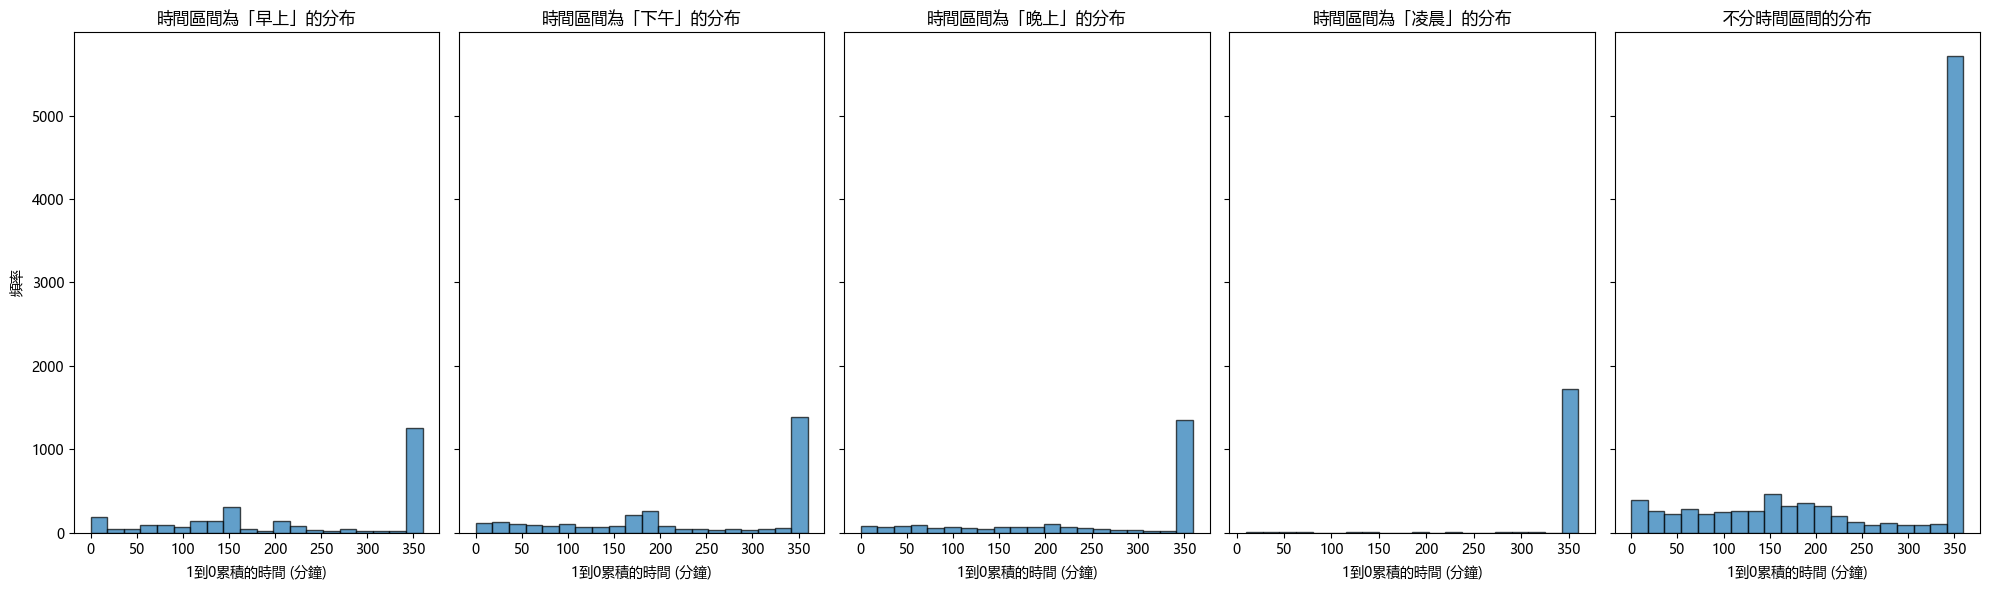

In [6]:
import matplotlib.pyplot as plt

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用 Microsoft YaHei 顯示中文
plt.rcParams['axes.unicode_minus'] = False  # 正常顯示負號

# 篩選出不同時間區間的資料
morning_data = utliT_df[utliT_df['時間區間'] == '早上']
afternoon_data = utliT_df[utliT_df['時間區間'] == '下午']
evening_data = utliT_df[utliT_df['時間區間'] == '晚上']
midnight_data = utliT_df[utliT_df['時間區間'] == '凌晨']
all_data = utliT_df  # 不分時間區間

# 建立並排的子圖
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharey=True)

# 繪製不同時間區間的分布圖
axes[0].hist(morning_data['1到0的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_title('時間區間為「早上」的分布')
axes[0].set_xlabel('1到0累積的時間 (分鐘)')
axes[0].set_ylabel('頻率')

axes[1].hist(afternoon_data['1到0的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[1].set_title('時間區間為「下午」的分布')
axes[1].set_xlabel('1到0累積的時間 (分鐘)')

axes[2].hist(evening_data['1到0的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[2].set_title('時間區間為「晚上」的分布')
axes[2].set_xlabel('1到0累積的時間 (分鐘)')

axes[3].hist(midnight_data['1到0的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[3].set_title('時間區間為「凌晨」的分布')
axes[3].set_xlabel('1到0累積的時間 (分鐘)')

axes[4].hist(all_data['1到0的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[4].set_title('不分時間區間的分布')
axes[4].set_xlabel('1到0累積的時間 (分鐘)')

# 調整佈局，並顯示圖表
plt.tight_layout()
plt.show()



# 同上述做法 0->1 Idle Time:

In [7]:
import pandas as pd
import numpy as np

# 定義時間區間
def get_period(hour):
    if 0 <= hour < 6:
        return '凌晨'
    elif 6 <= hour < 12:
        return '早上'
    elif 12 <= hour < 18:
        return '下午'
    else:
        return '晚上'

# 將「從 類別 == 0 到 類別 == 1」的時間差拆分為 6 小時時間段
def split_time_difference(start_time, end_time):
    time_diffs = []
    period_minutes = 360  # 每個時間區間 6 小時 = 360 分鐘
    current_time = start_time
    
    # 計算每一段的時間分配
    while current_time < end_time:
        current_period = get_period(current_time.hour)  # 確認當前時間的時間區間
        next_period_end = (current_time + pd.Timedelta(minutes=period_minutes)).replace(
            hour=(current_time.hour // 6 + 1) * 6 % 24, minute=0, second=0
        )  # 計算下一個時間區間的結束時間
        period_end = min(next_period_end, end_time)  # 取最小值（避免超過實際時間）
        
        # 計算當前時間段的分鐘數
        time_diff = int((period_end - current_time).total_seconds() // 60)
        time_diffs.append({'0到1的時間': time_diff, '時間區間': current_period})
        
        # 更新時間點
        current_time = period_end

    return time_diffs

# 篩選出所有的 (箱體ID, 儲格ID) 並計算類別 == 0 到 類別 == 1 的時間差
time_intervals = []

for (box_id, cell_id), group in status_filtered.groupby(['箱體ID', '儲格ID']):
    group = group.sort_values(by='資料建立日期時間').reset_index(drop=True)
    
    for i in range(len(group) - 1):
        if group.loc[i, '放(1)/取(0)'] == 0 and group.loc[i + 1, '放(1)/取(0)'] == 1:
            start_time = group.loc[i, '資料建立日期時間']
            end_time = group.loc[i + 1, '資料建立日期時間']
            
            # 擷取原始欄位的資料
            row_data = {
                '箱體ID': box_id,
                '儲格ID': cell_id,
                '儲格尺寸': group.loc[i, '儲格尺寸'],
                '箱到宅價錢(元)': group.loc[i, '箱到宅價錢(元)'],
                '箱到箱價錢(元)': group.loc[i, '箱到箱價錢(元)'],
                '建立星期': group.loc[i, '建立星期'],
                '日類型': group.loc[i, '日類型']
            }
            
            time_diffs = split_time_difference(start_time, end_time)
            
            for diff in time_diffs:
                diff.update({
                    **row_data,  # 添加原始欄位資料
                    '開始時間': start_time,
                    '結束時間': end_time
                })
                time_intervals.append(diff)

# 將結果轉為新的 DataFrame 並顯示
IdleT_df = pd.DataFrame(time_intervals)
IdleT_df


0到1的時間 時間區間  箱體ID  儲格ID 儲格尺寸  箱到宅價錢(元)  箱到箱價錢(元)      建立星期 日類型  \
0          327   下午  1779     2  小方格        60        55  Saturday  假日   
1          360   晚上  1779     2  小方格        60        55  Saturday  假日   
2          360   凌晨  1779     2  小方格        60        55  Saturday  假日   
3          360   早上  1779     2  小方格        60        55  Saturday  假日   
4          360   下午  1779     2  小方格        60        55  Saturday  假日   
...        ...  ...   ...   ...  ...       ...       ...       ...  ..   
133715     360   下午  2621    40  小方格        60        55  Saturday  假日   
133716     360   晚上  2621    40  小方格        60        55  Saturday  假日   
133717     360   凌晨  2621    40  小方格        60        55  Saturday  假日   
133718     360   早上  2621    40  小方格        60        55  Saturday  假日   
133719     251   下午  2621    40  小方格        60        55  Saturday  假日   

                          開始時間                    結束時間  
0      2022-01-01 12:32:50.300 2022-02-09 09:25:34.440  
1      2022-01-01 12:32:50.300 2022-02-09 09:25:34.440  
2      2022-01-01 12:32:50.300 2022-02-09 09:25:34.440  
3      2022-01-01 12:32:50.300 2022-02-09 09:25:34.440  
4      2022-01-01 12:32:50.300 2022-02-09 09:25:34.440  
...                        ...                     ...  
133715 2022-11-12 09:03:40.380 2022-11-20 16:11:32.880  
133716 2022-11-12 09:03:40.380 2022-11-20 16:11:32.880  
133717 2022-11-12 09:03:40.380 2022-11-20 16:11:32.880  
133718 2022-11-12 09:03:40.380 2022-11-20 16:11:32.880  
133719 2022-11-12 09:03:40.380 2022-11-20 16:11:32.880  

[133720 rows x 11 columns]

# 抽樣

In [8]:
import random

# 定義對應的時間區間
time_period_map = {
    0: '凌晨',
    1: '早上',
    2: '下午',
    3: '晚上'
}

# 抽樣函數
def IdleT_by_period(time_period, IdleT_df):
    # 確認輸入的 time_period 是否有效
    if time_period not in time_period_map:
        raise ValueError("time_period 必須是 0 (凌晨), 1 (早上), 2 (下午), 或 3 (晚上)")
    
    # 選取符合時間區間的資料
    target_period = time_period_map[time_period]
    filtered_df = IdleT_df[IdleT_df['時間區間'] == target_period]
    
    # 檢查是否有符合條件的數據
    if filtered_df.empty:
        print("沒有符合條件的數據。")
        return None
    
    # 抽樣一筆資料
    sampled_row = filtered_df.sample(1).iloc[0]
    
    # 返回 time_period 和 抽出的 '0到1的時間'
    return sampled_row['0到1的時間']

# 範例用法
time_period = 0  # 例如：凌晨
sampled_time_diff = IdleT_by_period(time_period, IdleT_df)
print(f"抽出的 '0到1的時間': {sampled_time_diff}")


抽出的 '0到1的時間': 360


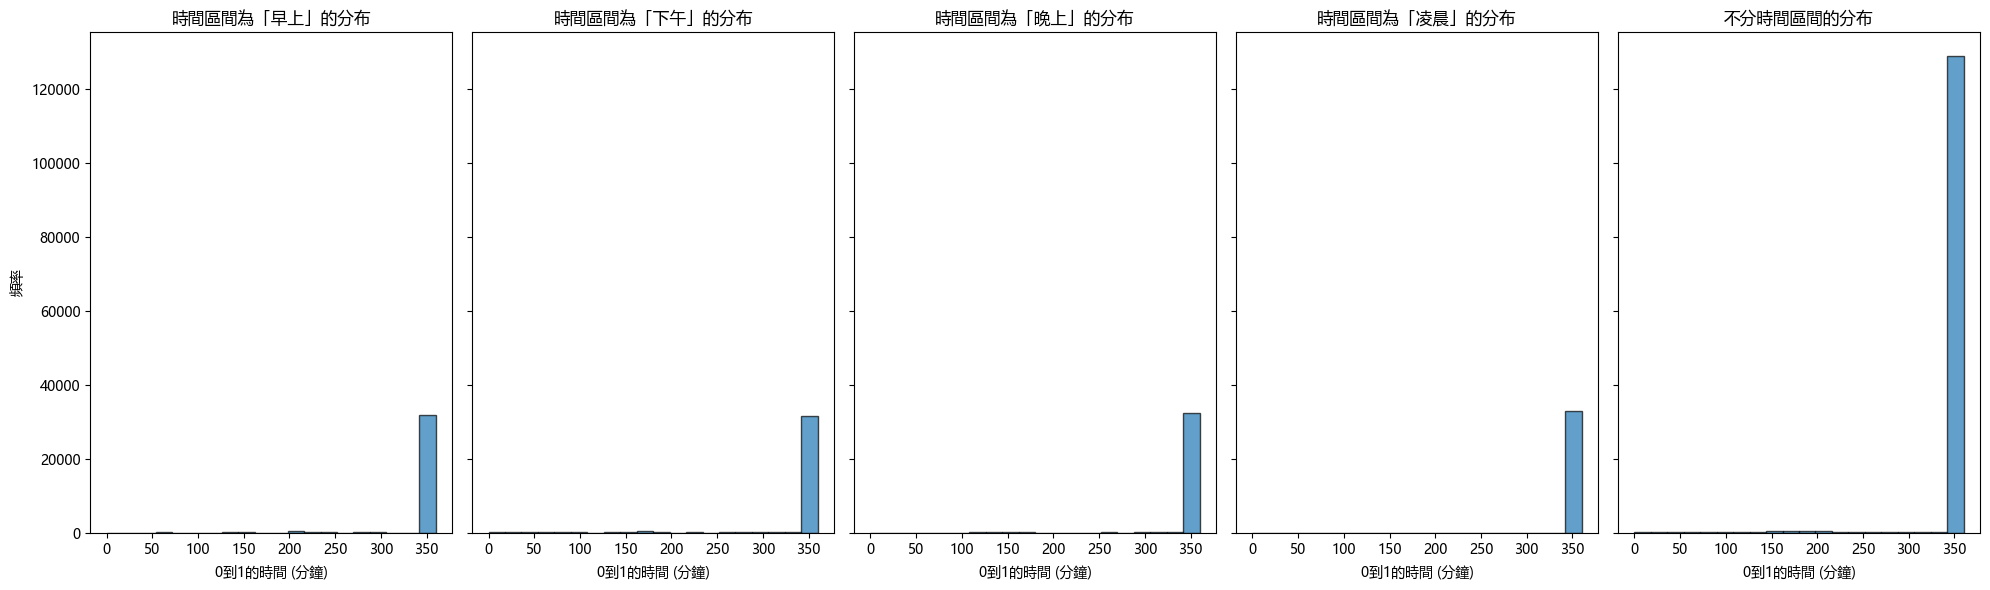

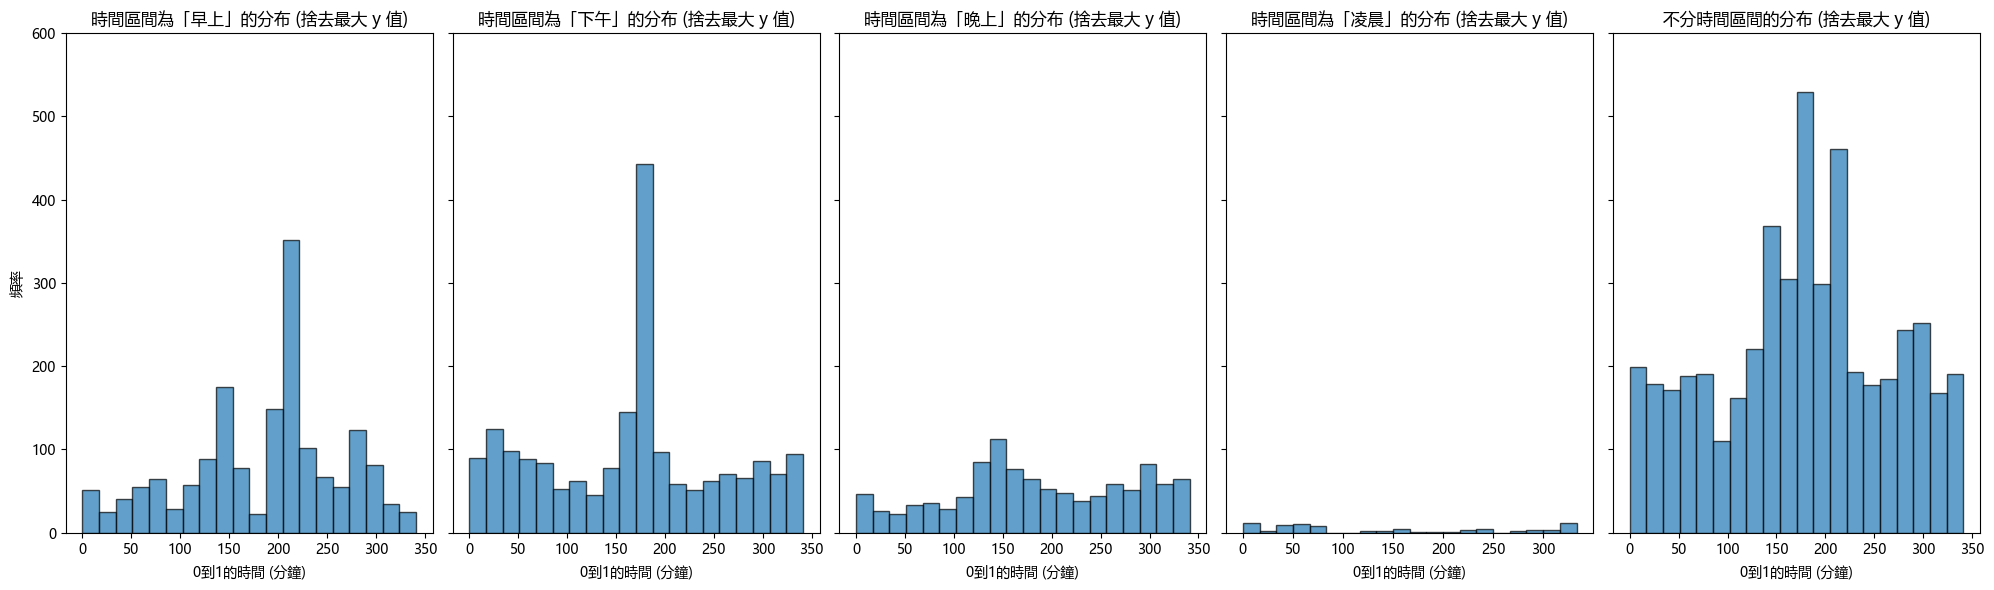

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用 Microsoft YaHei 顯示中文
plt.rcParams['axes.unicode_minus'] = False  # 正常顯示負號

# 篩選出不同時間區間的資料
morning_data = IdleT_df[IdleT_df['時間區間'] == '早上']
afternoon_data = IdleT_df[IdleT_df['時間區間'] == '下午']
evening_data = IdleT_df[IdleT_df['時間區間'] == '晚上']
midnight_data = IdleT_df[IdleT_df['時間區間'] == '凌晨']
all_data = IdleT_df  # 不分時間區間

# 計算每個時間區間的最大 y 值並移除超過最大值的資料
def remove_max_y_data(data, bins=20):
    counts, bin_edges = np.histogram(data['0到1的時間'], bins=bins)
    max_count = max(counts)  # 找到最大 y 值

    def within_max_count(x):
        bin_index = np.digitize(x, bin_edges) - 1
        # 確保 bin_index 在有效範圍內
        if 0 <= bin_index < len(counts):
            return counts[bin_index] < max_count
        return False

    # 過濾資料，僅保留在 max_count 以下的資料
    filtered_data = data[data['0到1的時間'].apply(within_max_count)]
    return filtered_data

morning_data_filtered = remove_max_y_data(morning_data)
afternoon_data_filtered = remove_max_y_data(afternoon_data)
evening_data_filtered = remove_max_y_data(evening_data)
midnight_data_filtered = remove_max_y_data(midnight_data)
all_data_filtered = remove_max_y_data(all_data)

# 第一排：原始的分布圖
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharey=True)

axes[0].hist(morning_data['0到1的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_title('時間區間為「早上」的分布')
axes[0].set_xlabel('0到1的時間 (分鐘)')
axes[0].set_ylabel('頻率')

axes[1].hist(afternoon_data['0到1的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[1].set_title('時間區間為「下午」的分布')
axes[1].set_xlabel('0到1的時間 (分鐘)')

axes[2].hist(evening_data['0到1的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[2].set_title('時間區間為「晚上」的分布')
axes[2].set_xlabel('0到1的時間 (分鐘)')

axes[3].hist(midnight_data['0到1的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[3].set_title('時間區間為「凌晨」的分布')
axes[3].set_xlabel('0到1的時間 (分鐘)')

axes[4].hist(all_data['0到1的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[4].set_title('不分時間區間的分布')
axes[4].set_xlabel('0到1的時間 (分鐘)')

plt.tight_layout()
plt.show()

# 第二排：捨去最大 y 值的分布圖，並將 y 軸限制在 0 到 5000
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharey=True)

axes[0].hist(morning_data_filtered['0到1的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_title('時間區間為「早上」的分布 (捨去最大 y 值)')
axes[0].set_xlabel('0到1的時間 (分鐘)')
axes[0].set_ylabel('頻率')
axes[0].set_ylim(0, 600)

axes[1].hist(afternoon_data_filtered['0到1的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[1].set_title('時間區間為「下午」的分布 (捨去最大 y 值)')
axes[1].set_xlabel('0到1的時間 (分鐘)')
axes[1].set_ylim(0, 600)

axes[2].hist(evening_data_filtered['0到1的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[2].set_title('時間區間為「晚上」的分布 (捨去最大 y 值)')
axes[2].set_xlabel('0到1的時間 (分鐘)')
axes[2].set_ylim(0, 600)

axes[3].hist(midnight_data_filtered['0到1的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[3].set_title('時間區間為「凌晨」的分布 (捨去最大 y 值)')
axes[3].set_xlabel('0到1的時間 (分鐘)')
axes[3].set_ylim(0, 600)

axes[4].hist(all_data_filtered['0到1的時間'], bins=20, edgecolor='black', alpha=0.7)
axes[4].set_title('不分時間區間的分布 (捨去最大 y 值)')
axes[4].set_xlabel('0到1的時間 (分鐘)')
axes[4].set_ylim(0, 600)

plt.tight_layout()
plt.show()



# Demand 
- 寄件需求圖  (x: 人數 y: 計數)

In [10]:


def sample_daily_put_count():
    # 先篩選出寄件的資料
    put_only = status_filtered[status_filtered['放(1)/取(0)'] == 1]

    # 按天計算放件的數量
    daily_put_counts = put_only.groupby(put_only['資料建立日期時間'].dt.date).size().reset_index(name='每日寄件數量')

    print(daily_put_counts)

    daily_put_counts_values = daily_put_counts['每日寄件數量'].values
    sampled_put_count = np.random.choice(daily_put_counts_values)
    return sampled_put_count

sampled_put_count = sample_daily_put_count()
print(f"隨機抽樣的寄件數量: {sampled_put_count}")

       資料建立日期時間  每日寄件數量
0    2022-01-01       3
1    2022-01-02       2
2    2022-01-03       8
3    2022-01-04       5
4    2022-01-05      11
..          ...     ...
347  2022-12-27      14
348  2022-12-28       4
349  2022-12-29       9
350  2022-12-30       8
351  2022-12-31       1

[352 rows x 2 columns]
隨機抽樣的寄件數量: 4


In [11]:
import numpy as np
import pandas as pd

def sample_daily_put_count():
    # 先篩選出寄件的資料
    put_only = status_filtered[status_filtered['放(1)/取(0)'] == 1]

    # 按天計算放件的數量
    daily_put_counts = put_only.groupby(put_only['資料建立日期時間'].dt.date).size().reset_index(name='每日寄件數量')

    # 計算三天的移動平均，以平滑數據
    daily_put_counts['平滑每日寄件數量'] = daily_put_counts['每日寄件數量'].rolling(window=3, min_periods=1).mean()

    # 使用平滑後的數據進行隨機抽樣
    daily_put_counts_values = daily_put_counts['平滑每日寄件數量'].values
    sampled_put_count = np.random.choice(daily_put_counts_values)

    return int(sampled_put_count)

# 測試抽樣
sampled_put_count = sample_daily_put_count()
print(f"隨機抽樣的寄件數量 (平滑後): {sampled_put_count}")


隨機抽樣的寄件數量 (平滑後): 5


### 寄件需求數量出現較大浮動的原因：

機率分布的長尾效應：若某些天的寄件數異常高，這會影響整體的機率分布，使得抽樣結果偏向較高的寄件數，從而增加了波動。特別是在節假日或活動日，可能會有明顯的寄件高峰，導致分布不均。

抽樣本身的隨機性：隨機抽樣會產生波動，即使在一個固定的機率分布下，每次抽樣的結果可能都有較大差異。如果對隨機波動較敏感，可以增加樣本數或進行平滑處理。

週期性或季節性影響：如果寄件需求存在週期性或季節性波動，這些模式會導致某些日子的需求異常高或低，而單純根據歷史分布進行隨機抽樣，可能無法準確反映這些週期性變化。

In [12]:
# 篩選 2022-08-31 這一天的資料
filtered_data = status_filtered[(status_filtered['資料建立日期時間'] >= "2022-08-30") & 
                                (status_filtered['資料建立日期時間'] < "2022-08-31")]
print(filtered_data)

# 計算 "放(1)/取(0)" 等於 1 的行數
count_put_1 = status_filtered[status_filtered['放(1)/取(0)'] == 1].shape[0]

print(f"'放(1)/取(0)' 等於 1 的行數: {count_put_1}")





         箱體ID  儲格ID  快遞狀態                資料建立日期時間  放(1)/取(0) 儲格尺寸  箱到宅價錢(元)  \
6111637  2233     4    80 2022-08-30 07:47:26.200        0.0   中格        65   
6116287  2621    28    20 2022-08-30 09:31:32.370        1.0   大格        70   
6117319  2621    35    20 2022-08-30 09:44:16.470        1.0   中格        65   
6117349  2621    24    20 2022-08-30 09:44:39.980        1.0   中格        65   
6117368  2621     4    20 2022-08-30 09:45:04.200        1.0   中格        65   
...       ...   ...   ...                     ...        ...  ...       ...   
6163880  2233    34    80 2022-08-30 17:21:05.770        0.0   中格        65   
6168041  2233    37    80 2022-08-30 18:49:07.780        0.0   中格        65   
6169823  1779     6    20 2022-08-30 20:08:10.630        1.0   中格        65   
6169831  1779    17    20 2022-08-30 20:08:25.480        1.0   中格        65   
6170084  2621    18    80 2022-08-30 20:20:11.940        0.0   大格        70   

         箱到箱價錢(元)     建立星期 日類型 時間區間  
6111637      

In [13]:
# 篩選出 2022-08-30 這一天的資料
filtered_data_day = status_filtered[
    (status_filtered['資料建立日期時間'] >= "2022-08-30") &
    (status_filtered['資料建立日期時間'] < "2022-08-31")
]

# 按箱體ID 和 儲格ID 分組，分別計算 "放(1)/取(0)" 等於 1 和 0 的行數
count_put_1 = filtered_data_day[filtered_data_day['放(1)/取(0)'] == 1].groupby(['箱體ID', '儲格ID']).size().reset_index(name='放(1)的總數')
count_put_0 = filtered_data_day[filtered_data_day['放(1)/取(0)'] == 0].groupby(['箱體ID', '儲格ID']).size().reset_index(name='取(0)的總數')

# 合併結果，方便查看每個箱體和儲格的放(1)/取(0)計數
result = pd.merge(count_put_1, count_put_0, on=['箱體ID', '儲格ID'], how='outer').fillna(0)
result['放(1)的總數'] = result['放(1)的總數'].astype(int)
result['取(0)的總數'] = result['取(0)的總數'].astype(int)

# 顯示結果
print("2022-08-30 每個箱體ID和儲格ID的'放(1)/取(0)'統計:")
print(result)

# 顯示總數
print(f"\n總共 '放(1)' 的行數: {count_put_1['放(1)的總數'].sum()}")
print(f"總共 '取(0)' 的行數: {count_put_0['取(0)的總數'].sum()}")





2022-08-30 每個箱體ID和儲格ID的'放(1)/取(0)'統計:
    箱體ID  儲格ID  放(1)的總數  取(0)的總數
0   1779     6        1        0
1   1779    14        0        1
2   1779    17        1        0
3   1779    28        1        1
4   1779    38        1        2
5   2233     4        0        1
6   2233    27        0        1
7   2233    34        1        1
8   2233    37        1        1
9   2233    40        0        1
10  2621     2        1        1
11  2621     3        1        1
12  2621     4        3        2
13  2621     5        2        2
14  2621     6        2        2
15  2621     7        2        2
16  2621     9        1        1
17  2621    12        1        1
18  2621    13        1        1
19  2621    14        2        2
20  2621    15        3        3
21  2621    16        2        2
22  2621    17        0        1
23  2621    18        2        2
24  2621    19        1        1
25  2621    20        1        1
26  2621    22        1        1
27  2621    23        1        1
28  2

In [14]:
import pandas as pd

# 篩選出 2022-08-30 這一天的資料
filtered_data_day = status_filtered[
    (status_filtered['資料建立日期時間'] >= "2022-08-30") &
    (status_filtered['資料建立日期時間'] < "2022-08-31")
]

# 新增一列表示小時
filtered_data_day['hour'] = filtered_data_day['資料建立日期時間'].dt.hour

# 按小時分組，計算 "放(1)/取(0)" 等於 1 和 0 的次數
count_by_hour = filtered_data_day.groupby(['hour', '放(1)/取(0)']).size().unstack(fill_value=0)

# 重命名欄位
count_by_hour.columns = ['取(0)的計數', '放(1)的計數']

# 顯示結果
print("2022-08-30 每小時的 '放(1)/取(0)' 計數分佈:")
print(count_by_hour)


2022-08-30 每小時的 '放(1)/取(0)' 計數分佈:
      取(0)的計數  放(1)的計數
hour                  
7           1        0
9          16       28
10         32       20
11          0        1
12          1        1
14          3        0
15          2        3
17          1        2
18          1        0
20          1        2


C:\Users\Ella\AppData\Local\Temp\ipykernel_15428\132231134.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_day['hour'] = filtered_data_day['資料建立日期時間'].dt.hour


# Demand 
- 寄件時間分布  (x: 時間(分鐘為單位) y: 計數)
- 取時間（以分鐘為單位）：hour_minute 欄位將 資料建立日期時間 轉換成「從午夜開始的分鐘數」，計算方法是 小時 * 60 + 分鐘。
- 統計計數：使用 value_counts().sort_index() 統計各分鐘的寄件數量(['放(1)/取(0)']==1)，並按時間順序排序。

C:\Users\Ella\AppData\Local\Temp\ipykernel_15428\2343195090.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  status_filtered_demand['hour_minute'] = status_filtered_demand['資料建立日期時間'].dt.hour * 60 + status_filtered_demand['資料建立日期時間'].dt.minute


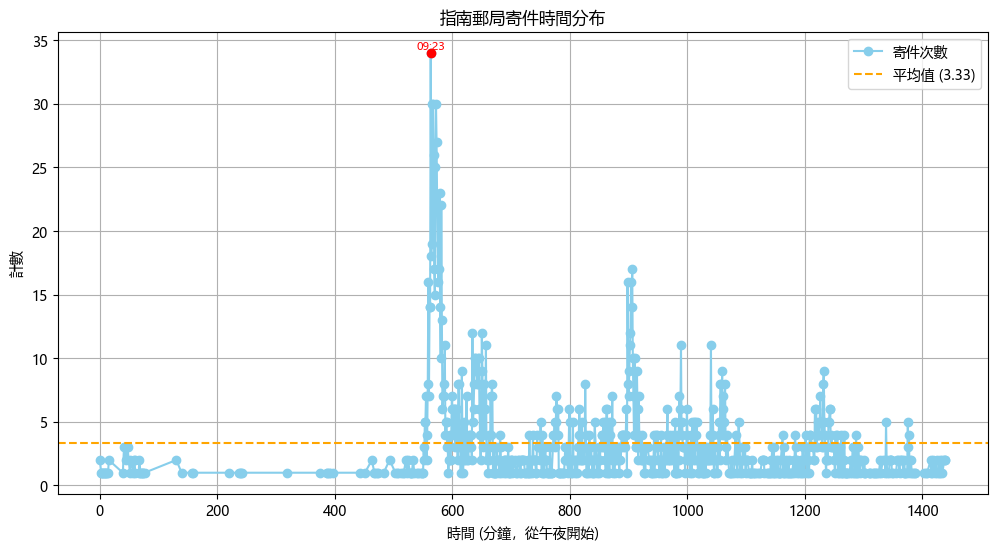

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 篩選出 "放(1)/取(0)" 等於 1 的資料
status_filtered_demand = status_filtered[status_filtered['放(1)/取(0)'] == 1]

# 從資料建立日期時間提取時間（以分鐘為單位）
status_filtered_demand['hour_minute'] = status_filtered_demand['資料建立日期時間'].dt.hour * 60 + status_filtered_demand['資料建立日期時間'].dt.minute

# 統計各分鐘的寄件計數
time_distribution = status_filtered_demand['hour_minute'].value_counts().sort_index()

# 計算平均值
average_count = time_distribution.mean()

# 設置較大值的閾值（如平均值的 10 倍）
threshold = average_count * 10

# 繪製寄件時間分布圖
plt.figure(figsize=(12, 6))
plt.plot(time_distribution.index, time_distribution.values, marker='o', linestyle='-', color='skyblue', label='寄件次數')

# 添加平均線
plt.axhline(y=average_count, color='orange', linestyle='--', label=f"平均值 ({average_count:.2f})")

# 標出較大的值
for minute, count in time_distribution.items():
    if count > threshold:
        plt.text(minute, count, f"{minute//60:02}:{minute%60:02}", ha='center', va='bottom', color='red', fontsize=8)
        plt.plot(minute, count, 'ro')  # 用紅色標記較大值

# 設置圖表標題和軸標籤
plt.title("指南郵局寄件時間分布")
plt.xlabel("時間 (分鐘，從午夜開始)")
plt.ylabel("計數")

# 添加圖例和格線
plt.legend()
plt.grid(True)
plt.show()



In [16]:
import numpy as np

import numpy as np

def calculate_sampled_minute(time_distribution):
    # 獲取每分鐘的時間（從午夜開始的分鐘數）和其對應的出現次數（作為機率權重）
    minutes = time_distribution.index
    probabilities = time_distribution.values / time_distribution.values.sum()  # 計算每分鐘的出現機率

    # 根據機率分布進行隨機抽樣，得出今天的寄件時間（以分鐘為單位）
    sampled_minute = np.random.choice(minutes, p=probabilities)
    
    return sampled_minute

# 使用示例
sampled_minute = calculate_sampled_minute(time_distribution)
print(f"隨機抽樣的分鐘數: {sampled_minute}")




隨機抽樣的分鐘數: 568


# 電腦模擬
1) **模擬儲格一天的狀態**
  - **初始狀態抽樣**: 
    - **step 0.**儲格每日的初始狀態(凌晨00:00:00.000)的機率
    - 狀態 0 的機率: 0.9594
    - 狀態 1 的機率: 0.0406
    - 紀錄為start_status 
  - **時間區段抽樣**: 
    - 每日時間區段 ( 凌晨 00:00-06:00->早上 06:00-12:00->下午 12:00-18:00->晚上 18:00-24:00 ，各六小時 )都各有兩個機率分布 : IdleT(0->1) 跟 UtliT(1->0)
    - **step 2.**  
      - 初始化df: box_i_status，存之後抽樣出來的資料，欄位要有: 一天初始狀態(step 0)、凌晨[[a,b],[c,d]]、早上[[a,b],[c,d]]、下午[[a,b],[c,d]]、晚上[[a,b],[c,d]]、末端狀態(初始化為99)
      - 初始化目前時間區段變數: now_time_status  = 0 or 1 or 2 or 3 (凌晨 ,早上,下午,晚上)
      - 紀錄是否滿360分鐘: timeup = 0  
      - 紀錄溢出時間: overflow_time = 0       
    - **step 3.**  根據剛才抽到的初始狀態是0還是1 ，對凌晨的分布抽樣
      - 初始狀態是0 : 抽凌晨的IdleT(0->1) 
        - 若抽出值等於360，則box_i_status['凌晨']=[0,360],[1,0]，box_i_status['末端狀態']=0。
        - 小於360(假設為a)，則box_i_status['凌晨']=[0,抽出值a],[1,0]，box_i_status['末端狀態']=1；並且從凌晨的UtliT(1->0)分布再抽一個分鐘數(假設為b)，紀錄box_i_status['凌晨']=[0,抽出值a],[1,max(360-抽出值a,抽出值b)]，box_i_status['末端狀態']=0；若max(360-抽出值a,抽出值b) 還沒>=360，就繼續根據以下sudocode流程重複值到 >= 360
      - 初始狀態是1 : 同上述邏輯，只是要改成更改box_i_statusbox_i_status[time_period][1][1]
```python

# 範例sudo code: 
# 假設目前box_i_status[now_time_status] = [0,300],[1,0] 
# 此時box_i_status['末端狀態'] == 1

while (now_time_status <=4):
  # 判斷末端狀態為1時，抽 UtliT(1->0) 分布
  if box_i_status['末端狀態'] == 1:
      # 實作抽取 UtliT(1->0) 分布的邏輯，抽出 抽出值
      box_i_status[now_time_status] = [0,300],[1,抽出值] # 紀錄
      timeup += 抽出值
      if max(360,timeup)<360:
        box_i_status['末端狀態']=0
        # 實作抽取 IdleT(0->1) 分布的邏輯 (因為box_i_status['末端狀態']== 0) 
      else if max(360,timeup)>=360:
        box_i_status['末端狀態']=1 
        overflow_time = (300+抽出值)-360 #紀錄溢出時間
        now_time_status += 1  #進入下一個時間區段
      else:
        ptint('error') 
        break
  

  # 判斷末端狀態為0時，抽取當下時間區間的 IdleT(0->1)
  else if box_i_status['末端狀態'] == 0:
    # 實作抽取 IdleT(0->1) 分布的邏輯
    # pass
  else 
    ptint('error') 
    break


```


      
2) 模擬寄件需求
3) 計算目標函數: 成功寄件次數 * price - 失敗寄件次數 * price - (cost = idle_cost if 今天寄件需求 == 0 else 0)
4) 目標函數為y ， 郵箱數量為x ，作圖

In [17]:
# import random

# # 抽樣每日初始狀態
# def sample_start_status():
#     # 定義 0 和 1 的抽樣機率
#     states = [0, 1]
#     probabilities = [0.9594, 0.0406]
#     start = random.choices(states, probabilities)[0]
#     print(start)
#     return start


def box_status_simulate(daily_start_status):
    # 假設初始化的 box_i_status, now_time_status, timeup, overflow_time
    box_i_status = {
      '一天初始狀態': daily_start_status,
      '末端狀態': daily_start_status,
      0: [[0, 0], [1, 0]],  # 0: 凌晨
      1: [[0, 0], [1, 0]],  # 1: 早上
      2: [[0, 0], [1, 0]],  # 2: 下午
      3: [[0, 0], [1, 0]]   # 3: 晚上``
   }
    time_period = 0  # 0: 凌晨, 1: 早上, 2: 下午, 3: 晚上
    timeup = 0
    time_period = 0
    while time_period <= 3:
        sample = 0 #抽出值
        overflow_time = 0
        timeup = 0
        overflow_time = 0
        # 判斷末端狀態為1時，抽 UtliT(1->0) 分布
        if box_i_status['末端狀態'] == 1:
            # 抽取 UtliT(1->0) 分布的值，並更新狀態
            sample = utilT_by_period(time_period,utliT_df) # 抽樣 UtliT(1->0) 分布邏輯
            
            if min(360,box_i_status[time_period][1][1] + sample) == 360 : # 如果現有陣列加上抽樣的會超過360
              box_i_status[time_period][1][1] = 360 # 避免超過360分鐘
              overflow_time = box_i_status[time_period][1][1] + sample - 360
              if overflow_time>0 and time_period < 3: #若有溢出的時間
                  time_period+=1
                  box_i_status[time_period][1][1] += overflow_time
                  time_period-=1
            else :
                box_i_status[time_period][1][1] += sample 
              
            timeup += box_i_status[time_period][1][1]
            
            if timeup < 360:
                box_i_status['末端狀態'] = 0
                sample = IdleT_by_period(time_period,IdleT_df) # 抽樣 IdleT(0->1) 分布邏輯
                if min(360,box_i_status[time_period][0][1] + sample) == 360 : # 如果現有陣列加上抽樣的會超過360
                    box_i_status[time_period][0][1] = 360 # 避免超過360分鐘
                    overflow_time = box_i_status[time_period][0][1] + sample - 360
                    if overflow_time>0 and time_period < 3: #若有溢出的時間
                        time_period+=1
                        box_i_status[time_period][0][1] += overflow_time
                        time_period-=1  
                    else :
                        box_i_status[time_period][0][1] += sample 
                        
                    timeup += box_i_status[time_period][0][1]
                # overflow_time = sample+box_i_status[time_period][0][1] - 360
                # if overflow_time > 0 : #若有溢出的時間
                #   box_i_status[time_period][0][1] = 360 # 只更改 0 的陣列
                #   if time_period <3:
                #     time_period+=1
                #     box_i_status[time_period][0][1] += overflow_time
                #     time_period-=1
                # else:
                #   box_i_status[time_period][0][1] += sample
                # timeup += sample
                # 進入下一次迭代(不進入下一個時間區段)
            else:
                box_i_status['末端狀態'] = 1 # 不改變末端狀態
                overflow_time = timeup - 360
                time_period += 1  # 進入下一個時間區段
                if overflow_time>0 and time_period < 3: #若有溢出的時間
                    box_i_status[time_period][0][1] += overflow_time # 只更改 0 的陣列(空箱時間) # 先記錄overflow_time 到新的時間區段

        # 判斷末端狀態為0時，抽取當下時間區間的 IdleT(0->1)
        elif box_i_status['末端狀態'] == 0:
            # 抽取 IdleT(0->1) 分布的值，並更新狀態
            sample = IdleT_by_period(time_period,IdleT_df) # 抽樣 IdleT(0->1) 分布邏輯
            
            if min(360,box_i_status[time_period][0][1] + sample) == 360 : # 如果現有陣列加上抽樣的會超過360
              box_i_status[time_period][0][1] = 360 # 避免超過360分鐘
              overflow_time = box_i_status[time_period][0][1] + sample - 360
              if overflow_time>0 and time_period < 3: #若有溢出的時間
                  time_period+=1
                  box_i_status[time_period][0][1] += overflow_time
                  time_period-=1
            else :
                box_i_status[time_period][0][1] += sample 
              
            timeup += box_i_status[time_period][0][1]
            
            if timeup < 360:
                box_i_status['末端狀態'] = 1
                box_i_status[time_period][1][1] = 360 - timeup
                timeup = 360
                # sample = utilT_by_period(time_period,utliT_df) # 抽樣 UtliT(1->0) 分布邏輯
                
                # overflow_time = sample+box_i_status[time_period][1][1] - 360
                # # 進入下一次迭代(不進入下一個時間區段)
                # if overflow_time > 0 : #若有溢出的時間
                #   box_i_status[time_period][1][1] = 360 # 只更改 0 的陣列
                #   if time_period <3:
                #     time_period+=1
                #     box_i_status[time_period][1][1] += overflow_time
                #     time_period-=1
                #   else:
                #     box_i_status[time_period][1][1] += sample
                # timeup += sample
                # 進入下一次迭代(不進入下一個時間區段)
            else:
                box_i_status['末端狀態'] = 0 # 不改變末端狀態
                
                overflow_time = timeup - 360
                time_period += 1  # 進入下一個時間區段
                if overflow_time > 0 and time_period < 3: #若有溢出的時間
                    box_i_status[time_period][1][1] += overflow_time # 只更改 1 的陣列(滿箱時間) # 先記錄overflow_time 到新的時間區段
            
        else:
            print('error')
            return 'error'
            
    return box_i_status


In [18]:
import random

# 抽樣每日初始狀態
def sample_start_status():
    # 定義 0 和 1 的抽樣機率
    states = [0, 1]
    probabilities = [0.9594, 0.0406]
    start = random.choices(states, probabilities)[0]
    print(start)
    return start


def box_status_simulate(daily_start_status, utliT_df, IdleT_df):
    # 初始化 box_i_status 結構
    box_i_status = {
        '一天初始狀態': daily_start_status,
        '末端狀態': daily_start_status,
        0: [[0, 0], [1, 0]],  # 0: 凌晨
        1: [[0, 0], [1, 0]],  # 1: 早上
        2: [[0, 0], [1, 0]],  # 2: 下午
        3: [[0, 0], [1, 0]]   # 3: 晚上
    }
    time_period = 0  # 0: 凌晨, 1: 早上, 2: 下午, 3: 晚上
    overflow_time = 0

    while time_period <= 3:
        sample = 0  # 抽出值
        overflow_time = 0
        
        # 判斷末端狀態為 1 時，抽 UtliT(1->0) 分布
        if box_i_status['末端狀態'] == 1:
            sample = utilT_by_period(time_period, utliT_df)
            new_util_time = box_i_status[time_period][1][1] + sample
            # 確保每個區段總時間不超過 360
            total_time = box_i_status[time_period][0][1] + new_util_time
            if total_time >= 360:
                box_i_status[time_period][1][1] = 360 - box_i_status[time_period][0][1]
                overflow_time = total_time - 360
                box_i_status['末端狀態'] = 1  # 不改變末端狀態
            
            else: # 抽出時間小於360
              box_i_status[time_period][1][1] = new_util_time
              box_i_status['末端狀態'] = 0  # 更新末端狀態
              print('yes')
            if overflow_time > 0 and time_period < 3:
                time_period += 1
                box_i_status[time_period][1][1] = min(360, overflow_time)
                overflow_time = 0  # 重置溢出時間
                box_i_status['末端狀態'] = 1  # 不改變末端狀態

        # 判斷末端狀態為 0 時，抽取當下時間區間的 IdleT(0->1)
        elif box_i_status['末端狀態'] == 0:
            sample = IdleT_by_period(time_period, IdleT_df)
            new_idle_time = box_i_status[time_period][0][1] + sample
            

            # 確保每個區段總時間不超過 360
            total_time = new_idle_time + box_i_status[time_period][1][1]
            if total_time >= 360:
                box_i_status[time_period][0][1] = 360 - box_i_status[time_period][1][1]
                overflow_time = total_time - 360
                box_i_status['末端狀態'] = 0  # 不改變末端狀態
            else: # 抽出時間小於360
                box_i_status[time_period][0][1] = new_idle_time
                box_i_status['末端狀態'] = 1  # 更新末端狀態
                print('yes')

            if overflow_time > 0 and time_period < 3:
                time_period += 1
                box_i_status[time_period][0][1] = min(360, overflow_time)
                overflow_time = 0  # 重置溢出時間
                box_i_status['末端狀態'] = 0  # 不改變末端狀態

        # 進入下一個時間區段
        if box_i_status[time_period][0][1] + box_i_status[time_period][1][1] >= 360:
            time_period += 1  # 進入下一個時間區段
    
    return box_i_status

In [19]:
# n = 50 #儲格數量
# box_n_status = []

# # 抽樣每日初始狀態
# daily_start_status = sample_start_status()

# for i in range(n) :
#   # 根據每日初始狀態，抽出儲格狀態
#   result = box_status_simulate(daily_start_status, utliT_df, IdleT_df)
#   box_n_status.append(result)

In [20]:

# box_n_status


In [21]:
# people = sample_daily_put_count()
# demand = []
# for i in range(people):
#   demand.append(calculate_sampled_minute(time_distribution))

# # 將需求時間排序
# demand_sorted = sorted(demand)

# # 將排序後的需求時間轉為字串，並用逗號分隔
# demand_str = ', '.join(str(time) for time in demand_sorted)

# # 顯示結果
# print(f'\n今天有 {people} 個寄件需求\n在 {demand_str} 分鐘寄件')


def generate_daily_demand():
    # 生成今天的寄件需求數量
    people = sample_daily_put_count()

    # 根據需求數量隨機抽樣時間
    demand = [calculate_sampled_minute(time_distribution) for _ in range(people)]

    # 排序需求時間
    demand_sorted = sorted(demand)

    # 將需求時間轉為字串，並顯示結果
    demand_str = ', '.join(str(time) for time in demand_sorted)
    print(f'\n今天有 {people} 個寄件需求\n在 {demand_str} 分鐘寄件')

    return demand_sorted

# 使用示例
# demand_times = generate_daily_demand(time_distribution)
# print(demand_times)

generate_daily_demand()
  


今天有 32 個寄件需求
在 386, 557, 562, 565, 572, 573, 574, 578, 585, 587, 588, 637, 646, 646, 736, 745, 855, 885, 889, 901, 905, 920, 1008, 1057, 1128, 1148, 1154, 1163, 1240, 1252, 1340, 1421 分鐘寄件


[386,
 557,
 562,
 565,
 572,
 573,
 574,
 578,
 585,
 587,
 588,
 637,
 646,
 646,
 736,
 745,
 855,
 885,
 889,
 901,
 905,
 920,
 1008,
 1057,
 1128,
 1148,
 1154,
 1163,
 1240,
 1252,
 1340,
 1421]


今天有 9 個寄件需求
在 552, 554, 567, 581, 636, 772, 864, 1040, 1087 分鐘寄件
0
0
0
0
0
0
yes
yes
0
1
yes
0

今天有 4 個寄件需求
在 582, 719, 898, 1082 分鐘寄件
0
yes
yes
0
yes
0
0

今天有 2 個寄件需求
在 719, 1185 分鐘寄件
0
0
yes
yes

今天有 9 個寄件需求
在 565, 567, 574, 744, 902, 949, 1064, 1344, 1368 分鐘寄件
0
0
0
0
0
0
0
0
yes
yes
0

今天有 9 個寄件需求
在 651, 740, 815, 857, 935, 994, 1065, 1233, 1246 分鐘寄件
0
0
0
0
yes
0
0
0
yes
yes
0
0

今天有 5 個寄件需求
在 640, 748, 890, 1019, 1219 分鐘寄件
0
1
yes
0
0
0

今天有 7 個寄件需求
在 569, 616, 900, 900, 906, 1205, 1421 分鐘寄件
0
0
0
0
0
0
0
yes

今天有 6 個寄件需求
在 572, 581, 921, 1183, 1249, 1387 分鐘寄件
0
0
yes
yes
0
0
yes
yes
0
yes
0

今天有 5 個寄件需求
在 561, 638, 837, 866, 912 分鐘寄件
0
yes
0
yes
yes
0
0
0

今天有 7 個寄件需求
在 47, 780, 862, 943, 1098, 1193, 1338 分鐘寄件
0
0
0
yes
0
yes
yes
0
0
yes
0

今天有 7 個寄件需求
在 47, 570, 584, 602, 825, 888, 998 分鐘寄件
0
0
0
0
0
0
0

今天有 8 個寄件需求
在 565, 777, 911, 999, 1208, 1267, 1291, 1433 分鐘寄件
0
0
0
0
yes
yes
0
0
0
0

今天有 5 個寄件需求
在 567, 573, 848, 862, 1221 分鐘寄件
0
0
0
0
yes
1
yes

今天有 5 個寄件需求
在 591, 667, 

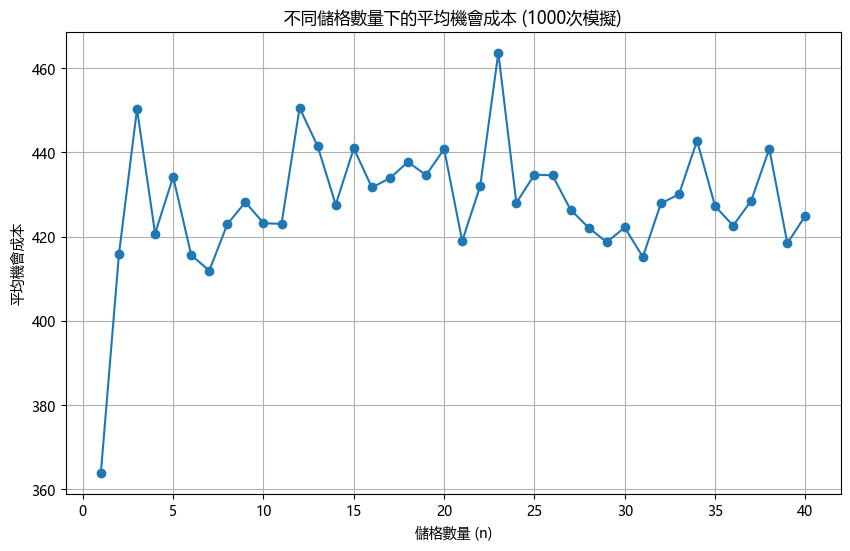

In [22]:
import random
import matplotlib.pyplot as plt

# 價格和成本參數
price = 60  # 每次寄件的價格
idle_cost = 10  # 若今天無寄件需求的成本


def generate_daily_demand():
    # 生成今天的寄件需求數量
    people = sample_daily_put_count()

    # 根據需求數量隨機抽樣時間
    demand = [calculate_sampled_minute(time_distribution) for _ in range(people)]

    # 排序需求時間
    demand_sorted = sorted(demand)

    # 將需求時間轉為字串，並顯示結果
    demand_str = ', '.join(str(time) for time in demand_sorted)
    print(f'\n今天有 {people} 個寄件需求\n在 {demand_str} 分鐘寄件')

    return demand_sorted
def calculate_sampled_minute(time_distribution):
    # 獲取每分鐘的時間（從午夜開始的分鐘數）和其對應的出現次數（作為機率權重）
    minutes = time_distribution.index
    probabilities = time_distribution.values / time_distribution.values.sum()  # 計算每分鐘的出現機率

    # 根據機率分布進行隨機抽樣，得出今天的寄件時間（以分鐘為單位）
    sampled_minute = np.random.choice(minutes, p=probabilities)
    
    return sampled_minute

# 定義機會成本的計算函數
def calculate_opportunity_cost(n, price, idle_cost):
    success_counts = 0
    failure_counts = 0
    opportunity_costs = []

    # 生成寄件需求
    daily_demands = generate_daily_demand()
    for demand_time in daily_demands:
        success = False
        box_n_status = []

        for i in range(n):
            # 抽樣每日初始狀態
            daily_start_status = sample_start_status()
            # 模擬當天儲格狀態
            result = box_status_simulate(daily_start_status, utliT_df, IdleT_df)
            box_n_status.append(result)

            # 計算需求所屬的 time_period
            remaining_time = demand_time
            time_period = 0
            while remaining_time >= 360:
                remaining_time -= 360
                time_period += 1
            
            # 判斷此 time_period 的閒置時間是否大於需求剩餘時間
            if result[time_period][0][1] >= remaining_time:
                success_counts += 1
                success = True
                break  # 成功後不再檢查其他儲格
            
        if not success:
            failure_counts += 1

    # 計算當天機會成本
    opportunity_cost = success_counts * price - failure_counts * price - (idle_cost if len(daily_demands) == 0 else 0)
    return opportunity_cost

# 模擬並繪製機會成本
n_values = list(range(1, 41))  # 儲格數量從 1 到 40
opportunity_costs = []

# 進行1000次模擬
num_simulations = 1000
for n in n_values:
    total_cost = 0
    for _ in range(num_simulations):
        total_cost += calculate_opportunity_cost(n, price, idle_cost)
    # 計算平均機會成本
    average_cost = total_cost / num_simulations
    opportunity_costs.append(average_cost)

# 繪製圖表
plt.figure(figsize=(10, 6))
plt.plot(n_values, opportunity_costs, marker='o')
plt.xlabel("儲格數量 (n)")
plt.ylabel("平均機會成本")
plt.title("不同儲格數量下的平均機會成本 (1000次模擬)")
plt.grid()
plt.show()


